In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('train_FD001.txt', sep=' ', header=None)

# dropping NAN values
df = df.dropna(axis=1, how='all')

# Naming the columns
df.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]
# # show dataframe
# df.head()



In [ ]:
# data preprocessing; removing unnecessary data
df.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df.head()


# MinMaxScaler
scaler = MinMaxScaler()
df.iloc[:,2:18] = scaler.fit_transform(df.iloc[:,2:18])

In [ ]:
df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

df['TTF'] = df['maxcycles'] - df['cycles']

def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / (dat.TTF.max()-dat.TTF.min())

fTTFz = []
fTTF = []

for i in range(df['unit'].min(),df['unit'].max()+1):
    dat=df[df.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
df['fTTF'] = fTTF
df

,unit,cycles,Op1,Op2,S2,S3,S4,S7,S8,S9,S11,S12,S13,S14,S15,S17,S20,S21,maxcycles,TTF,fTTF
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,192,191,1.000000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,192,190,0.994764
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,192,189,0.989529
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,192,188,0.984293
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,192,187,0.979058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,200,4,0.020101
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,200,3,0.015075
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,200,2,0.010050
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,200,1,0.005025


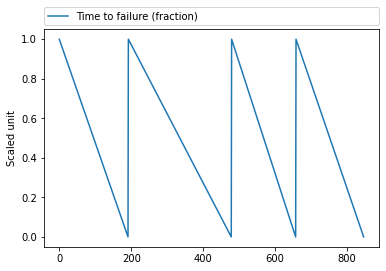

In [ ]:
cycles = df.groupby('unit', as_index=False)['cycles'].max()
mx = cycles.iloc[0:4,1].sum()

plt.plot(df.fTTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [ ]:
# splitting train and test data, test size 20%

# train set
df_train = df[(df.unit <= 80)]
X_train = df_train[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train[['fTTF']].values.ravel()

# test set
df_test = df[(df.unit > 80)]
X_test = df_test[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_test = df_test[['fTTF']].values.ravel()

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(Dense(50, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
16138/16138 [==============================] - 1s 32us/step - loss: 0.1774
Epoch 2/50
16138/16138 [==============================] - 0s 28us/step - loss: 0.0061
Epoch 3/50
16138/16138 [==============================] - 0s 27us/step - loss: 0.0053
Epoch 4/50
16138/16138 [==============================] - 0s 27us/step - loss: 0.0052
Epoch 5/50
16138/16138 [==============================] - 0s 26us/step - loss: 0.0048
Epoch 6/50
16138/16138 [==============================] - 0s 26us/step - loss: 0.0048
Epoch 7/50
16138/16138 [==============================] - 0s 27us/step - loss: 0.0052
Epoch 8/50
16138/16138 [==============================] - 0s 26us/step - loss: 0.0050
Epoch 9/50
16138/16138 [==============================] - 0s 27us/step - loss: 0.0050
Epoch 10/50
16138/16138 [==============================] - 0s 27us/step - loss: 0.0045
Epoch 11/50
16138/16138 [==============================] - 0s 27us/step - loss: 0.0050
Epoch 12/50
16138/16138 [===========================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


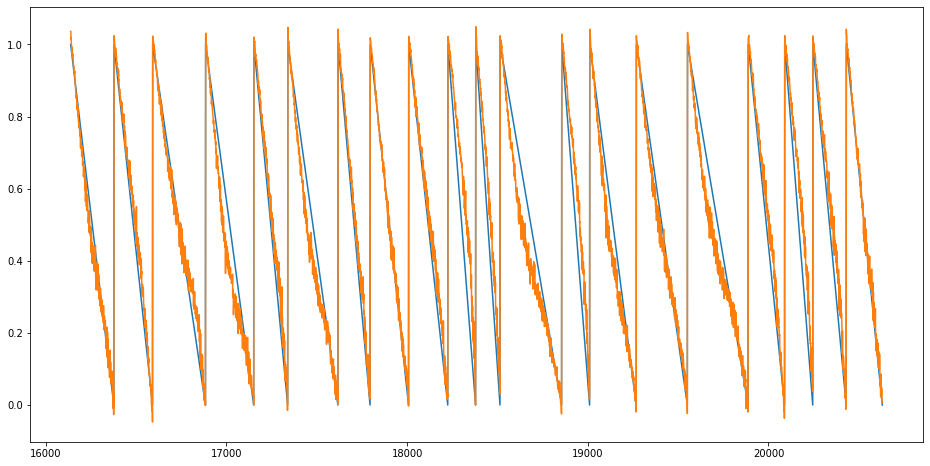

In [ ]:
score = model.predict(X_test) 
df_test['predicted'] = score

plt.figure(figsize = (16, 8)) 
plt.plot(df_test.fTTF) 
plt.plot(df_test.predicted)

In [ ]:
# RMSE
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

nn_rmse = sqrt(mean_squared_error(y_test, score))
print("RMSE: ", nn_rmse)

# r2 score
nn_r2 = r2_score(y_test, score)
print("r2 score: ", nn_r2)

RMSE:  0.07214345032748204
r2 score:  0.9380976102786726


In [ ]:
import numpy as np
a = np.array(df_test['predicted'].values.tolist())